In [1]:
import os
import numpy as np
import pandas as pd
import shutil
from read_roi import read_roi_file
import tifffile
import matplotlib.pyplot as plt
import create_mask_for_region
from datetime import datetime
from contour_visualization import *

#import shap
# read heatmap plots
#import Heatmap_plots as hmp
import seaborn as sns
import pickle
import tifffile as tiff

def flatten_extend(matrix):
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

In [2]:
# set figure key
figure_key = 'Figure2'

In [3]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)

# load meta info of the files
metadf = pd.read_csv(os.path.join(metapath,"OP_meta.csv"),index_col= False)
# temporary drop of A7 due to missing data
metadf = metadf[metadf.ID != 'A7'].reset_index(drop = True)
# load brain atlas to register
atlas_df = pd.read_csv(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\atlas_info_KimRef_FPbasedLabel_v4.0_brain_with_size_with_curated_with_cleaned_acronyms.csv",index_col = False)
metacolumns = ['id','acronym','parent_acronym','parent_id','structure_order']
contour_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v2.9_contour_map.tif")
# retrieve list of files
fnames =  [f for f in metadf.fname.values if 'DONE' in f]

In [4]:
#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)

# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
from adjustText import adjust_text

# Set matplotlib parameters for white text on transparent background
plt.rcParams.update({
    'figure.facecolor': 'none',  # Transparent figure background
    'axes.facecolor': 'none',    # Transparent axes background
    'axes.edgecolor': 'black',   # White axes edge color
    'axes.labelcolor': 'black',  # White axis labels
    'xtick.color': 'black',      # White tick labels
    'ytick.color': 'black',      # White tick labels
    'legend.facecolor': 'none',  # Transparent legend background
    'legend.edgecolor': 'none',  # Transparent legend edgecolor
    'text.color': 'black',       # White text color
    'font.family':'Arial',
    'pdf.fonttype':42,
    'ps.fonttype':42,
   
})
#important for text to be detected when importing saved figures into illustrator


In [6]:
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)

In [7]:
default_depth = 4
# set heatmap variables
vmin= -5
vmax = 10

#Conditions = metadf.Condition.unique()
# Use only morphine related groups
Conditions = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
print(Conditions)
#Condition_figure_name = ['Saline','Acute','Chronic 1 day','W.D. 1 day','Chronic 21 days','W.D. 21 days'] # changed this to betterones
Condition_figure_name = ['Saline','Acute','Chronic','Early WD','Re-exposure','Late WD'] 
Condition_color = ['gray','lime','orange','cyan','blue','purple']
# subset the meta dataframe
metadf = metadf[metadf.Condition.isin(Conditions)]

# load and subset dataframes
pivot_heatmap_df = pd.read_csv(os.path.join(analysis_resultpath,'long_pivoted_heatmap_df_with_normalized_density.csv'),index_col = 0)
pivot_heatmap_df = pivot_heatmap_df[metadf[metadf.Condition.isin(Conditions)]['ID'].values]
merge_df  = pd.read_csv(os.path.join(analysis_resultpath,'Ex_639_Ch2_stitched_long_merge_Annotated_counts_with_leaf_with_density_with_normalized_density.csv'),index_col = 0)
merge_df = merge_df[merge_df.Condition.isin(Conditions)]
# Load the acronyms for plotting
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'rb') as handle:
    curated_acronyms = pickle.load(handle)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'rb') as handle:
    ancestor_curated_acronyms = pickle.load(handle,)


['Saline', 'Acute_Morphine', 'Chronic_Morphine', 'Withdrawal_Morphine', 'Chronic_Morphine_21', 'Withdrawal_Morphine_21']


remove HB and CBL from the list of ancestores

In [8]:
# Update the ancestor curated acronyms so it matches the tree devisions
unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB',]
#unique_ancestor_curated_acronyms = ['Isocortex','OLF','HPF','CTXsp','STR','PAL','TH','HY','MB','HB','CBL']

# get a list of idx for the ancestors
ancestor_names = [atlas_df.loc[atlas_df.acronym == f,'name'].values[0] for f in unique_ancestor_curated_acronyms]
ancestor_idxs = [atlas_df.loc[atlas_df.acronym == f,'id'].values[0] for f in unique_ancestor_curated_acronyms]
'''
curated_acronyms = []
ancestor_curated_acronyms = []
for idx,i in enumerate(ancestor_idxs):
    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)
    curated_acronyms += list(tdf[tdf.Curated_list].acronym)
    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]

# save the new list of acronyms
with open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(curated_acronyms,handle,)

with open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:
    pickle.dump(ancestor_curated_acronyms,handle,)'''

"\ncurated_acronyms = []\nancestor_curated_acronyms = []\nfor idx,i in enumerate(ancestor_idxs):\n    create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    tdf = create_mask_for_region.get_subregions(atlas_df,i,return_original = True)\n    curated_acronyms += list(tdf[tdf.Curated_list].acronym)\n    ancestor_curated_acronyms += [unique_ancestor_curated_acronyms[idx]]*tdf[tdf.Curated_list].shape[0]\n\n# save the new list of acronyms\nwith open(os.path.join(analysis_resultpath,f'curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(curated_acronyms,handle,)\n\nwith open(os.path.join(analysis_resultpath,f'ancestor_curated_acronym.pickle'), 'wb') as handle:\n    pickle.dump(ancestor_curated_acronyms,handle,)"

remove CBL and MB subtree from the atlas file and the merge_df

In [9]:
# remove CBL and MB subtree from the data. These regions had bad registration quality and low interest
remove_ancestor_ids = atlas_df[(atlas_df.acronym == 'HB') | (atlas_df.acronym == 'CBL')]['id'].values
remove_df = pd.concat([create_mask_for_region.get_subregions(atlas_df,idx,return_original = True) for idx in remove_ancestor_ids],axis = 0)
sub_atlas_df = atlas_df.set_index(['id']).drop(remove_df['id'].values)
merge_df = merge_df[merge_df.acronym.isin(sub_atlas_df.acronym.unique())]

set up the metacolumns to be compatible for GLM

In [10]:
# load meta info of the files
metadf['age'] = [(datetime.strptime( pday, '%m/%d/%Y') - datetime.strptime( dob, '%m/%d/%Y')).days for pday,dob in metadf.loc[:,['Date_Perfusion','DOB']].values]
atlasmeta = merge_df.reset_index().loc[merge_df.reset_index().ID =='A1',['id','parent_id','acronym','name','parent_acronym']]

#metaexog = metadf[['Condition','Sex','BW','age','Staining_Batch']]
#metacolumns = ['Saline','Acute_Morphine','Chronic_Morphine','Sex_d','Batch_d']


In [11]:
# change categorical values to dummy chategories dtypes
sex_category = pd.CategoricalDtype(categories=['F', 'M'], ordered=False)
condition_category = pd.CategoricalDtype(categories=Conditions, ordered=True)
batch_category = pd.CategoricalDtype(categories=[1,2,3,4], ordered=False)

merge_df['Sex']             = merge_df['Sex'].astype(sex_category)
merge_df['Condition']       = merge_df['Condition'].astype(condition_category)

merge_df['Staining_Batch']  = merge_df['Staining_Batch'].astype(batch_category)

# create dummy cats
condition_dummies           = pd.get_dummies(merge_df['Condition'])
sex_dummies                 = pd.get_dummies(merge_df['Sex']).loc[:,['F']].rename(columns = {'F':'Sex_d'}) # female 1
batch_dummies = pd.get_dummies(merge_df['Staining_Batch'])
batch_dummies.columns = [f'Batch_{c}_d' for c in range(4)]

merge_df                    = pd.concat([merge_df,condition_dummies,sex_dummies,batch_dummies],axis =1)

In [12]:
# add flags for conditions
#merge_df = pd.merge(merge_df,metadf[['ID','Acute_flag','Chronic_flag','Spontaneous_flag']],left_on = 'ID',right_on = 'ID')

In [13]:
# calculate effect size raw
raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\
.pivot(columns = 'Condition',index = 'acronym',values = 'density')

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_200352\3994839575.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  raw_effect_size_df = merge_df[['acronym','Condition','density']].groupby(['acronym','Condition',]).mean().reset_index()\


In [14]:
atlas_df.loc[atlas_df.acronym.isin(curated_acronyms),['acronym','name']].to_csv(os.path.join(metapath,'clean_curated_acronyms.csv'),index = False)

Prepare heatmaps into a dictionary format

In [15]:
# read an annotated atlas file
atlas_img = tifffile.imread(r"\\10.159.50.7\Analysis2\Ken\LSMS\ClearMap\clearmap_ressources_mouse_brain\ClearMap_ressources\Regions_annotations\Kim_ref_adult_FP-label_v4.0.tif")

# Figure 2

## Figure 2C, D and E

In [16]:
pannel_key = 'C'

### Preparation

In [17]:
# set conditions to compare
#sub_conditions  = ['Saline','Acute_Morphine']
sub_conditions  = ['Saline','Acute_Morphine','Chronic_Morphine','Withdrawal_Morphine','Chronic_Morphine_21','Withdrawal_Morphine_21',]
sub_IDs         = metadf[metadf.Condition.isin(sub_conditions)].ID.values
sub_merge_df    = merge_df[merge_df.Condition.isin(sub_conditions)]
#sub_pivot_df    = pivot_heatmap_df[sub_IDs]
sub_pivot_df    = merge_df.pivot(columns = 'ID',index= 'acronym',values = 'density')[sub_IDs]

### GLM test

Conduct a GLM test with a likelihood ratio test.

In [18]:
# scale the metacolumns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# First test if there is a difference in the average decay length between the 5 types.

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import fdrcorrection
import numpy as np
from scipy.stats import chi2
def chi2_model_comparison(model1,model2):
    # Get the log-likelihoods of the models
    ll_null = model1.llf  # log-likelihood of the full model
    ll_restricted = model2.llf  # log-likelihood of the restricted model

    # Calculate the difference in log-likelihoods
    ll_diff = -2 * (ll_restricted - ll_null)

    # Degrees of freedom is the difference in the number of parameters
    df = model1.df_model - model2.df_model

    # Compute the p-value
    p_value = chi2.sf(ll_diff, df)
    return p_value


In [19]:
# add a constant
sub_merge_df['constant'] = 1

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


A24a (IL)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
c:\Users\s

A24b' (Cg1)-6b
A24a' (Cg2)-6b
A32 (PrL)-2
A32 (PrL)-6b
LO-6b
MO-2/3


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


DLO-6a
DLO-6b
AIP-6b
AIV-6b
A29c (RSGc)-2


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


A25 (DP)-2
DTr


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuber

DLEnta
DLEntb
DLEnt4
DLEnt4/5
DLEnt5/6
DIEnt2a
DIEnt2b
DIEnt2/3
DIEnt4
DIEnt5/6
VIEnt4


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


6b


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


MCPO


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


Pi


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\varfuncs.py:265: RuntimeWarning: overflow encountered in square
  return p + self.alpha*p**2
c:\Users\stuberadmin\anaconda3\en

DA14
SChVM
Stg


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


TuLH
PeFLH


c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)
c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\statsmodels\genmod\families\family.py:1402: RuntimeWarning: invalid value encountered in divide
  endog_mu = self._clean(endog / mu)


ReIC
Me5


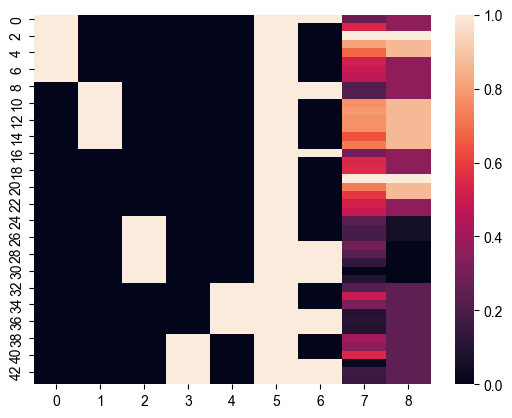

In [20]:
# set the metacolumns to use in the model
metacolumns = list(sub_conditions[1:]) + ['constant'] + ['Sex_d','BW','Age',]  # drop saline
# Select only continuous variables for scaling
continuous_vars = ['BW', 'Age']  # Modify as needed
scaler = MinMaxScaler()

# Predefine the link function
family = sm.families.NegativeBinomial()

for idx,acronym in enumerate(sub_merge_df.acronym.unique()):
    # don't run test if not enough subjects which seems to happen
    exog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),metacolumns]
    exog[continuous_vars] = scaler.fit_transform(exog[continuous_vars])
    endog = sub_merge_df.loc[(sub_merge_df.acronym == acronym),'density']
    if idx == 0:
        sns.heatmap(np.array(exog.astype('float')))
        
    
    try:
        # run multiple GLM fits and comparison while dropping one of the variables

        glmfit = sm.GLM(endog, np.asarray(exog.astype('float64')),family=family,).fit()
        tglmfit = sm.GLM(endog, exog.astype('float64').drop(columns = sub_conditions[1:]),family=family,).fit() # Drop the conditions

        pvalue = chi2_model_comparison(glmfit,tglmfit) # calculate the pvalue from the chi2 likelihood test of the two models
        tdf = pd.DataFrame([pvalue],columns = ['Condition'])
        tdf['acronym'] = acronym
    except:
        # if doesn't run, save a nan
        # tdf = pd.DataFrame({'F':np.nan,'PR(>F)':np.nan,'acronym':acronym},index = [0])
        print(acronym)
        #tdf = pd.DataFrame(np.nan * np.zeros((1,len(metacolumns))),columns = metacolumns) # put pvalue of 1 with empty
        tdf = pd.DataFrame([np.nan],columns = ['Condition']) # put pvalue of 1 with empty
        tdf['acronym'] = acronym
        #print(acronym, " did not have enough subjects")

    if idx == 0:
        glm_stat_df = tdf
    else:
        glm_stat_df = pd.concat([glm_stat_df,tdf],axis=  0,).reset_index(drop = True)


In [36]:
# Write the glm stat data frame
glm_stat_df = pd.merge(create_mask_for_region.get_subregions(atlasmeta, 8, return_original=True),glm_stat_df,left_on = 'acronym',right_on = 'acronym').\
    rename(columns = {'name':'Name','Condition':'pvalue'})
glm_stat_df.to_csv(os.path.join(analysis_resultpath,f'{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv'),index = False)
print(f'{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv')

Figure2_C_glm_stat_df_no_batch.csv


In [ ]:
import TreeBH
# you can run it with python too
'''input_csv = r"G:/My Drive/Opioid_whole_brain_manuscript/result/Figure2_C_glm_stat_df_no_batch.csv"
output_dir = r"G:/My Drive/Opioid_whole_brain_manuscript/result_test"
TreeBH.run_tree_fdr_pipeline(
    input_csv,
    output_dir,
    pval_col="pvalue",
    save_key="Figure2_C_glm_stat_df_no_batch",
    q_thresh=0.001,
    plot_html=True  # Set to False to skip HTML plot
)'''

### Run TreeBH to correct for multiple comparison

Run TreeFDR for the acute vs. saline GLM test results with a p=0.001 threshold. This will happen on a separate R script (Opioid_Figure 2_TreeBH.R)

In [21]:
# read the results from the treeFDR f
TreeFDRF_df = pd.read_csv(os.path.join(analysis_resultpath,\
    f'TreeFDRF_pvalue_{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv'),index_col = False)

In [22]:
f'TreeFDRF_pvalue_{figure_key}_{pannel_key}_glm_stat_df_no_batch.csv'

'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'

In [23]:
# get the rejected acronyms
rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.acronym.isin(curated_acronyms)) & (TreeFDRF_df.rejected == True)].acronym.values 
print(len(rejected_acronyms)," rejected acronyms")
print(rejected_acronyms)


85  rejected acronyms
['FrA' 'M1' 'M2' 'S1' 'S2' 'A24a (IL)' 'DI' 'GI' 'AuD' 'Au1' 'AuV' 'V2L'
 'V2M' 'V1' 'A24 (Cg)' 'A32 (PrL)' 'O' 'AI' 'A29-30 (RS)' 'PtA' 'TeA '
 'PRh' 'Ect' 'AO' 'TT' 'A25 (DP)' 'CA2' 'CA3' 'DLEnt' 'DIEnt' 'VIEnt'
 'MEnt' 'Post' 'PsS' 'DS' 'VeS' 'STr' 'Cl' 'La' 'CPre' 'CPr' 'CPi' 'CPc'
 'AcbC' 'AcbSh' 'IPAC' 'Tu' 'LS' 'Ce' 'ST' 'Sc' 'PIL' 'PP' 'MG' 'Po' 'PLi'
 'SG' 'AM' 'IAM' 'IAD' 'IMD' 'PoMn' 'MD' 'Sub' 'PVT' 'RE' 'Rh' 'CM' 'PC'
 'PrG' 'MBO' 'Com' 'VTA' 'PlPAG' 'MA3' 'PrEW' '4Sh' 'Pa4' 'VTg' 'SNC'
 'SPTg' 'IP' 'RLi ' 'CLi' 'DR']


array(['Cl_leaf', 'DCl', 'VCl', 'La_leaf'], dtype=object)

In [44]:
# get the proportion of leaf nodes that are rejected per major subtree
unique_ancestor_curated_acronyms = np.unique(ancestor_curated_acronyms)

for ancestor_acronym in unique_ancestor_curated_acronyms:
    # get the acnstor_id
    ancestor_id = atlas_df[atlas_df.acronym == ancestor_acronym].id.values[0]
    # get the subregions of the ancestor acronym
    subregions_df = create_mask_for_region.get_subregions(atlas_df,ancestor_id,return_original = True)
    # get the leafnodes
    leafnodes = np.setdiff1d(subregions_df['acronym'],subregions_df['parent_acronym'])
    # get the rejected acronyms in this subtree
    rejected_leafnodes = TreeFDRF_df[(TreeFDRF_df.acronym.isin(leafnodes))&(TreeFDRF_df.rejected == True)].acronym.values

    # calculate the proportion of rejected acronyms in this subtree
    proportion_rejected = len(rejected_leafnodes) / len(leafnodes)
    print(f"{ancestor_acronym}: {len(rejected_leafnodes)} / {len(leafnodes)} rejected")

CTXsp: 4 / 21 rejected
HPF: 15 / 81 rejected
HY: 3 / 98 rejected
Isocortex: 189 / 303 rejected
MB: 24 / 105 rejected
OLF: 3 / 60 rejected
PAL: 1 / 30 rejected
STR: 10 / 63 rejected
TH: 24 / 81 rejected


In [20]:
# get a list of rejected regions from the TreeFDR result
sub_rejected_acronyms = TreeFDRF_df[(TreeFDRF_df.rejected == True) & (TreeFDRF_df.acronym.isin(curated_acronyms))].acronym

### Plot for Figure C and D

Run a sunburst plot app. Plot the sunburst plot along with the betacoef result of acute morphine

In [21]:
# pannel
pannel_key = 'C'

In [24]:
import active_sunburst as sunburst
# reload function sunburst
import importlib
importlib.reload(sunburst)

betacoef = np.load(os.path.join(r"\\10.159.50.7\LabCommon\Ken\data\Opioid_cFos\result",f'Acute_Morphine_betas.npy'))
tTreeFDRF_df = pd.merge(TreeFDRF_df[['acronym','rejected','p.val']],atlas_df,left_on = 'acronym',right_on = 'acronym',how = 'inner')
sunburst.run_app(tTreeFDRF_df, betacoef, atlas_img, os.path.join(analysis_figurepath,f'{figure_key}_sunburst'),
data_variable = 'rejected',colormap =  plt.cm.coolwarm,cmin = -20,cmax = 20,)


g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:188: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar subtract

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar add

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar subtract

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar add

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar subtract

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar add

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: RuntimeWarning:

overflow encountered in scalar subtract

g:\My Drive\Opioid_whole_brain_manuscript\notebooks\active_sunburst.py:128: R

## Figure F

In [54]:
pannel_key = 'F'

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\4275355909.py:15: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



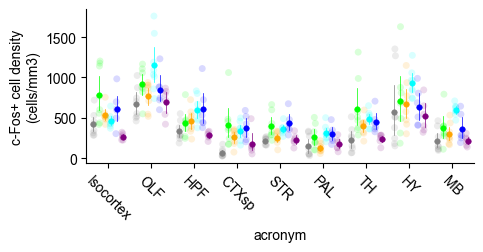

In [58]:
from statannotations.Annotator import Annotator

fig,axs = plt.subplots(1,1,figsize = (5,2))
tdata = merge_df.loc[merge_df.acronym.isin(ancestor_curated_acronyms),:]

sns.stripplot(data = tdata,hue = 'Condition',y = 'density',x = 'acronym',dodge = True,\
        hue_order = Conditions,ax = axs,palette = Condition_color,alpha = 0.15,order = unique_ancestor_curated_acronyms)
sns.pointplot(data = tdata,hue = 'Condition',y = 'density',x = 'acronym',dodge = .8-.8/len(np.unique(ancestor_curated_acronyms)),\
        hue_order = Conditions,ax = axs,palette = Condition_color,order = unique_ancestor_curated_acronyms,
markers="o", markersize=4, linestyle="none",linewidth = 0.5)        
sns.despine()
axs.set_ylabel('c-Fos+ cell density\n(cells/mm3)')
# remove the figure legend
axs.get_legend().remove()
axs.set_xticklabels(unique_ancestor_curated_acronyms,rotation = -45)

fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)


## Figure G

In [61]:
pannel_key = 'G'

In [63]:
# The convert the rejected column to -1, 0, 1 (Not-rejected, Not-tested, Rejected)
# Merge the results from multiple formats
a = TreeFDRF_df.loc[TreeFDRF_df.acronym.isin(curated_acronyms),['acronym','rejected']].astype('str').replace('nan',0).replace('False',-1).replace('True',1).rename(columns = {'rejected':'TreeBH_F'})
heatmapdf = pd.concat([a.set_index('acronym')],axis = 1)

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\51683262.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



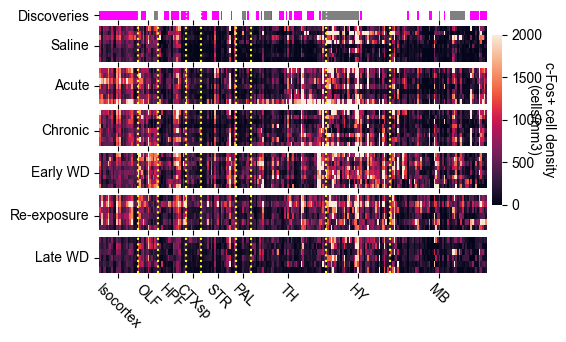

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm

# set parameters
vmin = 0
vmax = 2000

# Custom colormap for the first subplot
cmap = ListedColormap(['white', 'gray', 'magenta'])  # Colors for -1, 0, 1
bounds = [-1.5, -0.5, 0.5, 1.5]  # Boundaries for the values
norm = BoundaryNorm(bounds, cmap.N)

# Create the merged figure
total_rows = len(sub_conditions) + 1  # Adding one row for the second figure

fig, axs = plt.subplots(total_rows, 1, figsize=(5, len(sub_conditions)*0.4 + 1), sharex=True, \
    gridspec_kw={"height_ratios": [0.25] + [1] * len(sub_conditions)})
# Plot the first subplot (top row)
theatmapdf = heatmapdf.loc[curated_acronyms, ['TreeBH_F']]
subset_ancestor_curated_acronyms = [ancestor_curated_acronyms[idx] for idx, f in enumerate(curated_acronyms) if f in theatmapdf.index]

__, indexes = np.unique(subset_ancestor_curated_acronyms, return_index=True)
ytick_labels = [subset_ancestor_curated_acronyms[index] for index in sorted(indexes)]
counts = [len(np.where(np.array(subset_ancestor_curated_acronyms) == ylabel)[0]) for ylabel in ytick_labels]

borders = [0] + list(np.cumsum(counts))
x = np.array(borders)
yticks = (x[1:] + x[:-1]) / 2

sns.heatmap(data=theatmapdf.T, cbar=False, ax=axs[0], cmap=cmap, norm=norm)  # Applied custom colormap and norm
axs[0].set_xticks(yticks)
axs[0].set_xticklabels(ytick_labels, rotation=0)
axs[0].set_xlabel('')
[axs[0].axvline(border, color='white', lw=1, ls=':') for border in borders[1:-1]]
axs[0].set_yticks([0.5])
axs[0].set_yticklabels(['Discoveries'], rotation=0)

# Plot the remaining subplots
for idx, condition in enumerate(sub_conditions):
    subjects = metadf[(metadf.Condition == condition) & (metadf.fname)].ID.values
    if idx == len(sub_conditions) - 1:
        cbar_ax = fig.add_axes([axs[idx + 1].get_position().x1 + 0.01, axs[idx + 1].get_position().y0 + 0.2, 0.02, 0.5])  # Adjusted colorbar width
        sns.heatmap(data=sub_pivot_df.loc[curated_acronyms, subjects].T, cbar_ax=cbar_ax, ax=axs[idx + 1],\
             vmin=vmin, vmax=vmax)
        cbar_ax.set_ylabel('c-Fos+ cell density\n(cells/mm3)', rotation=270, labelpad=10, fontsize=10)
    else:
        sns.heatmap(data=sub_pivot_df.loc[curated_acronyms, subjects].T, cbar=False, ax=axs[idx + 1], vmin=vmin, vmax=vmax)
    
    axs[idx + 1].set_xticks(yticks)
    axs[idx + 1].set_xticklabels(ytick_labels, rotation=-45)
    axs[idx + 1].set_xlabel('')
    [axs[idx + 1].axvline(border, color='yellow', lw=1.5, ls=':') for border in borders[1:-1]]
    axs[idx + 1].set_yticks([len(subjects) // 2 + 0.5])
    axs[idx + 1].set_ylabel('')
    axs[idx + 1].set_yticklabels([Condition_figure_name[np.where(np.array(Conditions) == sub_conditions[idx])[0][0]]],rotation = 0)  
    #axs[idx + 1].set_yticklabels([Condition_figure_name[[np.where(Conditions == f)[0][0] for f in sub_conditions][idx]]], rotation=0)

# Save the merged figure
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.png'), bbox_inches='tight', dpi=216)
fig.savefig(os.path.join(analysis_figurepath, f'{figure_key}{pannel_key}.pdf'), bbox_inches='tight', dpi=216)


## Figure H

In [91]:
pannel_key = 'H'

In [80]:
"""
This script conducts two analyses on neural activity data:

1. Correlation Analysis:
   - Computes the pairwise Pearson correlation between the mean neural activity vectors (across brain regions)
     for each drug condition group.
   - Prints and plots the correlation matrix, and reports which condition pair has the highest correlation.

2. Classification Analysis:
   - Builds one‐vs‐rest logistic regression classifiers (using cross-validation) to predict the condition from neural activity.
   - Reports the cross-validated accuracy for each condition.

Data Assumptions:
 - pivot_heatmap_df: A DataFrame where rows are brain regions and columns are subject IDs.
 - metadf: A DataFrame with columns "ID" (subject ID) and "Condition" (drug condition information).

Make sure that the subject IDs in pivot_heatmap_df’s columns exactly match the IDs in metadf.
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score

def correlation_analysis(data, condition_labels):
    """
    Computes pairwise Pearson correlation coefficients between the mean neural activity vectors
    (across brain regions) for each condition.
    
    Parameters:
        data: numpy array of shape (n_regions, n_subjects)
        condition_labels: numpy array of shape (n_subjects,) with condition labels
        
    Returns:
        corr_matrix: (n_conditions x n_conditions) array of Pearson correlations.
        conditions_list: list of unique condition labels.
        best_pair: tuple (cond1, cond2) for the pair with the highest correlation.
        max_corr: highest correlation value.
    """
    unique_conditions = np.unique(condition_labels)
    mean_vectors = {}
    for cond in unique_conditions:
        # Find indices for subjects in this condition and compute mean activity across those subjects.
        idx = np.where(condition_labels == cond)[0]
        mean_vectors[cond] = np.mean(data[:, idx], axis=1)
        
    n = len(unique_conditions)
    corr_matrix = np.zeros((n, n))
    conditions_list = list(unique_conditions)
    
    for i in range(n):
        for j in range(n):
            vec_i = mean_vectors[conditions_list[i]]
            vec_j = mean_vectors[conditions_list[j]]
            corr = np.corrcoef(vec_i, vec_j)[0, 1]
            corr_matrix[i, j] = corr

    # Find the off-diagonal pair with the highest correlation.
    max_corr = -np.inf
    best_pair = (None, None)
    for i in range(n):
        for j in range(i+1, n):
            if corr_matrix[i, j] > max_corr:
                max_corr = corr_matrix[i, j]
                best_pair = (conditions_list[i], conditions_list[j])
                
    return corr_matrix, conditions_list, best_pair, max_corr

def plot_correlation_matrix(corr_matrix, conditions_list,outputpath = None,figsize = (5,4)):
    """
    Plots a heatmap of the correlation matrix.
    """
    fig,axs = plt.subplots(1,1,figsize=figsize)
    sns.heatmap(corr_matrix, annot=True, xticklabels=conditions_list,
                yticklabels=conditions_list, cmap="coolwarm", vmin=-1, vmax=1,ax = axs)
    axs.set_title("Correlation Matrix of Mean Neural Activity by Condition")
    axs.set_xlabel("Condition")
    axs.set_ylabel("Condition")
    if outputpath:
        fig.savefig(outputpath,dpi = 216,bbox_inches= 'tight')
        fig.savefig(outputpath.replace('.png','.pdf'),dpi = 216,bbox_inches= 'tight')
    #plt.show()

def classification_analysis(X_data, condition_labels, n_splits=5):
    """
    Performs one-vs-rest classification (using logistic regression) for each condition.
    
    Parameters:
        X_data: numpy array of shape (n_subjects, n_regions)
        condition_labels: numpy array of shape (n_subjects,)
        n_splits: number of folds for cross-validation
        
    Returns:
        clf_results: dictionary mapping each condition to its mean cross-validated accuracy.
    """
    unique_conditions = np.unique(condition_labels)
    clf_results = {}
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for cond in unique_conditions:
        # Create binary labels: 1 if the subject is in the current condition, 0 otherwise.
        y_binary = (condition_labels == cond).astype(int)
        clf = LogisticRegression(solver='liblinear', random_state=42)
        scores = cross_val_score(clf, X_data, y_binary, cv=skf, scoring='accuracy')
        mean_score = np.mean(scores)
        clf_results[cond] = mean_score
        print(f"Condition {cond}: Mean CV Accuracy = {mean_score:.3f}")
    
    return clf_results

def main(pivot_heatmap_df,metadf):
    # ----------------------------
    # Load the dataframes.
    # Adjust the file paths or replace with your loading mechanism as needed.
    # ----------------------------

    
    # pivot_heatmap_df: rows are brain regions, columns are subject IDs.
    # Convert the data to a numpy array.
    data = pivot_heatmap_df.values  # Shape: (n_regions, n_subjects)
    
    # Extract condition labels in the same order as the subject IDs (columns of pivot_heatmap_df).
    # This assumes that metadf['ID'] exactly matches the subject IDs in pivot_heatmap_df.columns.
    condition_labels = metadf.set_index('ID').loc[pivot_heatmap_df.columns, 'Condition'].values
    
    # ----------------------------
    # Part 1: Correlation Analysis
    # ----------------------------
    corr_matrix, conditions_list, best_pair, max_corr = correlation_analysis(data, condition_labels)
    print("Correlation Matrix (Mean Neural Activity by Condition):")
    for i, cond in enumerate(conditions_list):
        print(f"Condition {cond}: {corr_matrix[i]}")
    print(f"\nStrongest correlation is between Condition {best_pair[0]} and Condition {best_pair[1]} with r = {max_corr:.3f}")
    
    plot_correlation_matrix(corr_matrix, conditions_list)
    
    # ----------------------------
    # Part 2: Classification Analysis
    # ----------------------------
    # Transpose the data to have subjects as rows and brain regions as features.
    X_data = data.T  # Shape: (n_subjects, n_regions)
    print("\nPerforming one-vs-rest classification for each condition:")
    clf_results = classification_analysis(X_data, condition_labels, n_splits=5)
    return corr_matrix, conditions_list,clf_results

Correlation Matrix (Mean Neural Activity by Condition):
Condition Acute_Morphine: [1.         0.8314039  0.82064171 0.38199914 0.41830424]
Condition Chronic_Morphine: [0.8314039  1.         0.80703531 0.51222828 0.53164077]
Condition Chronic_Morphine_21: [0.82064171 0.80703531 1.         0.53649174 0.60098048]
Condition Withdrawal_Morphine: [0.38199914 0.51222828 0.53649174 1.         0.56331064]
Condition Withdrawal_Morphine_21: [0.41830424 0.53164077 0.60098048 0.56331064 1.        ]

Strongest correlation is between Condition Acute_Morphine and Condition Chronic_Morphine with r = 0.831

Performing one-vs-rest classification for each condition:
Condition Acute_Morphine: Mean CV Accuracy = 0.800
Condition Chronic_Morphine: Mean CV Accuracy = 0.829
Condition Chronic_Morphine_21: Mean CV Accuracy = 0.857
Condition Withdrawal_Morphine: Mean CV Accuracy = 0.914
Condition Withdrawal_Morphine_21: Mean CV Accuracy = 0.971


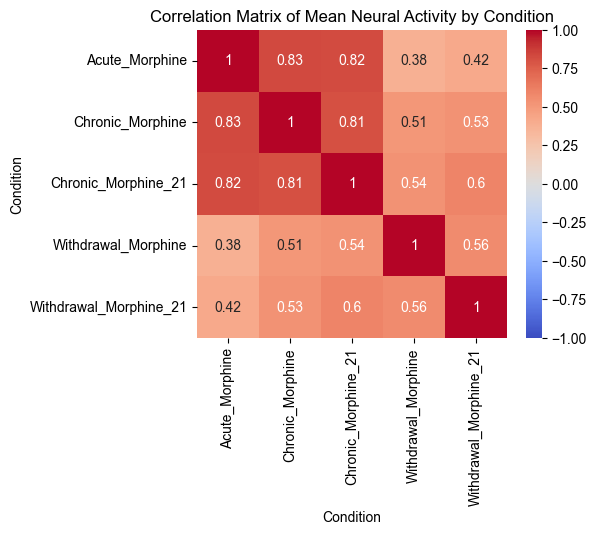

In [88]:
corr_matrix, conditions_list,clf_results = main(pivot_heatmap_df.loc[curated_acronyms,metadf[metadf.Condition != 'Saline'].ID]\
    ,metadf[metadf.Condition !='Saline'])

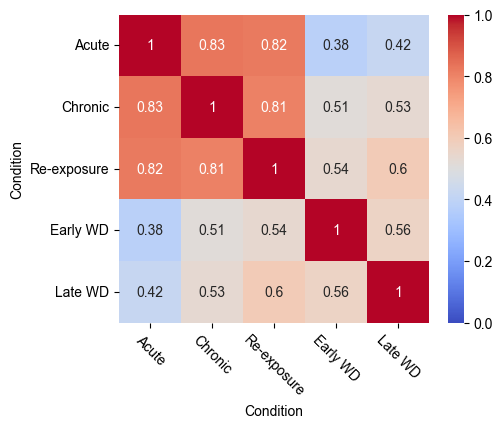

In [92]:
outputpath = os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png')
fig,axs = plt.subplots(1,1,figsize=(5,4))
sns.heatmap(corr_matrix, annot=True, xticklabels=conditions_list,
            yticklabels=conditions_list, cmap="coolwarm", vmin=0, vmax=1,ax = axs)
#axs.set_title("Correlation Matrix of Mean Neural Activity by Condition")
axs.set_xlabel("Condition")
axs.set_ylabel("Condition")
axs.set_xticklabels([Condition_figure_name[np.where(np.array(Conditions) == f)[0][0]] for f in conditions_list],rotation = -45)
axs.set_yticklabels([Condition_figure_name[np.where(np.array(Conditions) == f)[0][0]] for f in conditions_list],rotation = 0)

fig.savefig(outputpath,dpi = 216,bbox_inches= 'tight')
fig.savefig(outputpath.replace('.png','.pdf'),dpi = 216,bbox_inches= 'tight')

## Figure I

In [94]:
pannel_key = 'I'

In [121]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from scipy.stats import ttest_ind
from collections import defaultdict

def run_bootstrap_auc(X, y, n_iterations=1000, random_seed=42):
    """
    Perform one-vs-rest classification for each unique class in y,
    using bootstrap iterations and random shuffling for null distribution.

    Parameters:
    - X: np.ndarray, shape (n_samples, n_features), standardized input data
    - y: np.ndarray, shape (n_samples,), condition labels
    - n_iterations: int, number of bootstrap iterations
    - random_seed: int, base seed for reproducibility

    Returns:
    - results: dict, contains AUC distributions for each condition
    """
    np.random.seed(random_seed)
    unique_conditions = np.unique(y)
    results = {}

    for condition in unique_conditions:
        print(f"Running bootstrap for: {condition}")
        # Create binary labels: 1 for current condition, 0 for rest
        y_bin = (y == condition).astype(int)

        true_scores = []
        random_scores = []

        for i in tqdm(range(n_iterations)):
            try:
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y_bin, test_size=0.3, stratify=y_bin, random_state=i
                )
                # Skip if not both classes present
                if len(np.unique(y_test)) < 2:
                    continue

                rf = RandomForestClassifier(n_estimators=100, random_state=i)
                rf.fit(X_train, y_train)
                y_pred = rf.predict_proba(X_test)[:, 1]
                true_auc = roc_auc_score(y_test, y_pred)
                true_scores.append(true_auc)

                # Randomized label baseline
                y_train_shuffled = np.random.permutation(y_train)
                rf.fit(X_train, y_train_shuffled)
                y_pred_rand = rf.predict_proba(X_test)[:, 1]
                rand_auc = roc_auc_score(y_test, y_pred_rand)
                random_scores.append(rand_auc)
            except Exception as e:
                print(f"Skipping iteration {i} due to error: {e}")
                continue

        results[condition] = {
            "true_scores": np.array(true_scores),
            "random_scores": np.array(random_scores),
            "p_value": ttest_ind(true_scores, random_scores, equal_var=False)[1]
        }

    return results


In [122]:
from sklearn.preprocessing import StandardScaler


# use the normalized density dataframe as input
X = pivot_heatmap_df.loc[curated_acronyms,metadf[metadf.Condition != 'Saline']['ID'].values].values.T
# Standardize features (important for many classifiers)
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = metadf[metadf.Condition!= 'Saline']['Condition'].values

print(X.shape)


# Ensure input is standardized (already done above)
# scaler = StandardScaler()
# X = scaler.fit_transform(X)

results = run_bootstrap_auc(X, y, n_iterations=1000)

# Save for later
import pickle
with open("bootstrap_auc_results.pkl", "wb") as f:
    pickle.dump(results, f)


Running bootstrap for: Acute_Morphine


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


Running bootstrap for: Chronic_Morphine


100%|██████████| 1000/1000 [02:07<00:00,  7.85it/s]


Running bootstrap for: Chronic_Morphine_21


100%|██████████| 1000/1000 [02:08<00:00,  7.80it/s]


Running bootstrap for: Withdrawal_Morphine


100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]


Running bootstrap for: Withdrawal_Morphine_21


100%|██████████| 1000/1000 [02:07<00:00,  7.84it/s]


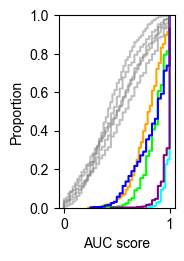

In [153]:
fig,axs = plt.subplots(1,1,figsize = (1.5,2.5))
for cidx,c in enumerate(Conditions):
    if c == 'Saline':
        continue

    sns.ecdfplot(results[c]['true_scores'], label=np.array(Condition_figure_name)[np.where(np.array(Conditions) == c)[0]][0],\
        color=Condition_color[cidx],ax= axs)
    sns.ecdfplot(results[c]['random_scores'], label='Shuffle',color='grey',alpha = 0.5,ax = axs)
axs.set_xlabel('AUC score')
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.png'),bbox_inches = 'tight',dpi = 216)
fig.savefig(os.path.join(analysis_figurepath,f'{figure_key}{pannel_key}.pdf'),bbox_inches = 'tight',dpi = 216)

# Figure 2-supplemental figure 1

In [363]:
# set figure key
figure_key = 'Figure2-supplemental figure 1'

In [364]:
# set paths
result_paths = r"\\10.159.50.7\analysis2\Ken\LSMS\Opioid"
rootpath = r"G:\My Drive\Opioid_whole_brain_manuscript"
metapath = os.path.join(rootpath,"meta")
analysis_resultpath = os.path.join(rootpath,"result")
analysis_root_figurepath = os.path.join(rootpath,"figure")
analysis_figurepath = os.path.join(analysis_root_figurepath,figure_key)
for path in [analysis_resultpath,analysis_root_figurepath,analysis_figurepath]:
    if not os.path.exists(path):
        os.mkdir(path)


## Figure A to H

Use the TreeBH results from Figure 2 and conduct comparisons with different multiple comparison approaches

### Preparation

In [365]:
# read the treebh stats
#opioid_treebh_df = pd.read_csv(os.path.join(datapath, "TreeFDRF_p_val_opioid.csv"))
opioid_stat_df = pd.read_csv(os.path.join(analysis_resultpath,\
    f'Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)

opioid_treebh_df = pd.read_csv(os.path.join(analysis_resultpath,\
    f'TreeFDRF_pvalue_Figure2_C_glm_stat_df_no_batch.csv'),index_col = False)
# FDR is set to 0.01 for the TreeBH 
FDR = 0.001

In [366]:
# run a flat bh correction on the opioid_df
import statsmodels.stats.multitest as multitests

# create a dataframe to store all the pvlaues corrected by different algorithms
# tree bh
opioid_bh_comparison_df = opioid_treebh_df.copy()
opioid_bh_comparison_df['Fishers_p_val'] = opioid_treebh_df['p.val'].astype(float)
opioid_bh_comparison_df['TreeBH_rejected'] = opioid_treebh_df['rejected']



In [367]:
# BH with Fisher's collected pvalues
fishers_pvals = opioid_treebh_df.set_index('acronym').loc[curated_acronyms,'p.val']
multiple_testing_results = multitests.multipletests(fishers_pvals, alpha=FDR, method='fdr_bh')
opioid_bh_comparison_df = opioid_bh_comparison_df.set_index('acronym')
opioid_bh_comparison_df.loc[curated_acronyms,'flatbh_Fishers_rejected'] = multiple_testing_results[0]
opioid_bh_comparison_df.loc[curated_acronyms,'flatbh_Fishers_p_val'] = multiple_testing_results[1]

In [368]:
# BH with pvalues calculated by averaged data
nonfishers_pvals = opioid_stat_df.set_index('acronym').loc[curated_acronyms,'pvalue']
multiple_testing_results = multitests.multipletests(nonfishers_pvals, alpha=FDR, method='fdr_bh')
opioid_bh_comparison_df.loc[curated_acronyms,'flatbh_non-Fishers_rejected'] = multiple_testing_results[0]
opioid_bh_comparison_df.loc[curated_acronyms,'flatbh_non-Fishers_p_val'] = multiple_testing_results[1]

In [369]:
# write the opioid_bh_comparison_df to csv file
opioid_bh_comparison_df = opioid_bh_comparison_df.reset_index()
opioid_bh_comparison_df.to_csv(os.path.join(analysis_resultpath, f"{figure_key}_opioid_bh_comparison_df.csv"), index = False)

In [20]:
TreeFDRF_df

NameError: name 'TreeFDRF_df' is not defined

### Plot the results

In [370]:
opioid_bh_comparison_df = pd.read_csv(os.path.join(analysis_resultpath, f"{figure_key}_opioid_bh_comparison_df.csv"), index_col = False)

In [371]:
comparison_keys = ['flatbh_non-Fishers','flatbh_Fishers','TreeBH',]

### Figure B

In [372]:
pannel_key = 'B'

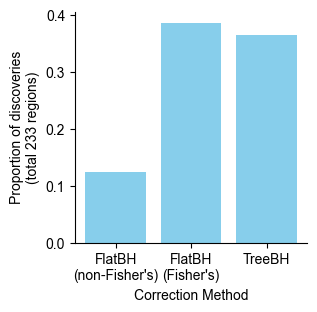

In [373]:
# plot the rejected results as a barplot, without a error bar
import matplotlib.pyplot as plt

# Prepare data for plotting
rejected_counts = {
    key: np.sum(opioid_bh_comparison_df.loc[opioid_bh_comparison_df.acronym.isin(curated_acronyms),f'{key}_rejected'] == True)/len(curated_acronyms)
    for key in comparison_keys
}

# Create barplot
plt.figure(figsize=(3,3))
plt.bar(comparison_keys, \
    [rejected_counts[f] for f in comparison_keys],color='skyblue')
plt.xlabel('Correction Method')
plt.ylabel(f'Proportion of discoveries\n(total {len(curated_acronyms)} regions)')
plt.xticks([0,1,2],["FlatBH\n(non-Fisher's)","FlatBH\n(Fisher's)","TreeBH",], rotation=0)
sns.despine()
plt.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"), dpi=300, bbox_inches='tight')


### Figure C

In [374]:
pannel_key = 'C'

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\matplotlib_venn\layout\venn3\pairwise.py:169: UserWarning:

Bad circle positioning.



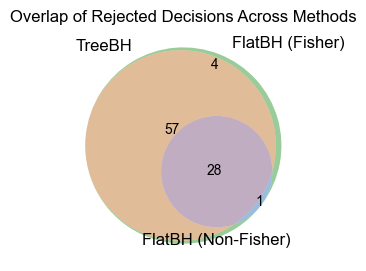

In [375]:
from matplotlib_venn import venn3

# Prepare data for Venn diagram
treebh_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['TreeBH_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
flatbh_fishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
flatbh_nonfishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_non-Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)

# Create Venn diagram
fig,axs = plt.subplots(figsize=(4,3))
venn3([treebh_rejected, flatbh_fishers_rejected, flatbh_nonfishers_rejected],
      ('TreeBH', 'FlatBH (Fisher)', 'FlatBH (Non-Fisher)'),ax = axs)
axs.set_title('Overlap of Rejected Decisions Across Methods')
fig.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"), dpi=300, bbox_inches='tight')
fig.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"), dpi=300, bbox_inches='tight')


### preparation

Deinfe Group A,B,C as A: True in all 3 methods, B: True in TreeBH and Fisher FlatBH but not in non Fisher, C: True only in Fisher FlatBH

In [376]:
# calculate the metrics for sets of brain regions in the brain_regions_category
# Prepare data for Venn diagram
treebh_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['TreeBH_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
flatbh_fishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
flatbh_nonfishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_non-Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)


In [377]:
# find the common in treebh_rejected, flatbh_fishers_rejected, flatbh_nonfishers_rejected
groupA = treebh_rejected & flatbh_fishers_rejected & flatbh_nonfishers_rejected

# find the common in treebh_rejected and flatbh_fishers_rejected but not in flatbh_nonfishers_rejected
groupB = (treebh_rejected & flatbh_fishers_rejected) - flatbh_nonfishers_rejected

# find only in flatbh_fishers_rejected but not in treebh_rejected and not in flatbh_nonfishers_rejected
groupC = (flatbh_fishers_rejected - treebh_rejected) - flatbh_nonfishers_rejected


In [378]:

# get the ancesotr acronyms 
groupA_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                           for f in groupA]
groupB_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                           for f in groupB]                           
groupC_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                           for f in groupC]


In [379]:
# get metrics for brain regions

# get ancestor of the brain region
def get_ancestor_acronym(atlas_df,acronym):
    """
    Get the ancestor acronym for a given acronym
    """
    if acronym in atlas_df['acronym'].values:
        ancestor_acronym = atlas_df[atlas_df['acronym'] == acronym]['ancestor_default_acronym'].values[0]
    else:
        ancestor_acronym = np.nan
    return ancestor_acronym

# get the number of siblings for a given acronym
def get_n_siblings(atlas_df,acronym):
    """
    Get the number of siblings for a given acronym
    """
    if acronym in atlas_df['acronym'].values:
        n_siblings = len(atlas_df[atlas_df['parent_acronym'] == atlas_df[atlas_df['acronym'] == acronym]['parent_acronym'].values[0]])
    else:
        n_siblings = np.nan
    return n_siblings

# get the number of children for a given acronym
def get_n_children(atlas_df,acronym):
    """
    Get the number of children for a given acronym
    """
    if acronym in atlas_df['acronym'].values:
        n_children = len(atlas_df[atlas_df['parent_acronym'] == acronym])
    else:
        n_children = np.nan
    return n_children

# get the number of siblings of the parent for a given acronym
def get_n_siblings_parent(atlas_df,acronym):
    """
    Get the number of siblings of the parent for a given acronym
    """
    if acronym in atlas_df['acronym'].values:
        parent_acronym = atlas_df[atlas_df['acronym'] == acronym]['parent_acronym'].values[0]
        try:
            grandparent_acronym = atlas_df[atlas_df['acronym'] == parent_acronym]['parent_acronym'].values[0]
            n_siblings_parent = len(atlas_df[atlas_df['parent_acronym'] == grandparent_acronym])
        except:
            n_siblings_parent = np.nan
    else:
        n_siblings_parent = np.nan
    return n_siblings_parent

# get the depth of the brain regions
def get_depth(atlas_df,acronym):
    """
    Get the depth of the brain region for a given acronym
    """
    if acronym in atlas_df['acronym'].values:
        depth = atlas_df[atlas_df['acronym'] == acronym]['depth'].values[0]
    else:
        depth = np.nan
    return depth

In [380]:
# get the acronyms that are unique to each method
brain_regions_category = [groupA,groupB,groupC]
brain_regions_category_name = ['groupA','groupB','groupC']

for bidx,brain_regions in enumerate(brain_regions_category):
    brain_regions = np.array(list(brain_regions))
    ancestor_acronyms = [get_ancestor_acronym(atlas_df,acronym) for acronym in brain_regions]
    n_siblings_list = [get_n_siblings(atlas_df,acronym) for acronym in brain_regions]
    n_children_list = [get_n_children(atlas_df,acronym) for acronym in brain_regions]
    n_siblings_parent_list = [get_n_siblings_parent(atlas_df,acronym) for acronym in brain_regions]
    depth_list = [get_depth(atlas_df,acronym) for acronym in brain_regions]
    # create a dataframe to store the metrics
    metrics_df = pd.DataFrame({
        'ancestor_acronym': ancestor_acronyms,
        'n_siblings': n_siblings_list,
        'n_children': n_children_list,
        'n_siblings_parent': n_siblings_parent_list,
        'depth': depth_list,
    },index = brain_regions)
    metrics_df['category'] = brain_regions_category_name[bidx]

    # merge the metrics_df from the iterations to one
    if bidx == 0:
        all_metrics_df = metrics_df.copy()
    else:
        all_metrics_df = pd.concat([all_metrics_df,metrics_df],axis = 0)    

### Figure D

In [381]:
pannel_key = 'D'

In [382]:
ancestor_counts

,category,ancestor_acronym,count
0,groupA,CTXsp,1
1,groupA,HPF,1
2,groupA,Isocortex,1
3,groupA,MB,11
4,groupA,STR,4
5,groupA,TH,10
6,groupB,CTXsp,1
7,groupB,HPF,10
8,groupB,HY,1
9,groupB,Isocortex,22


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\2035322232.py:19: UserWarning:

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.



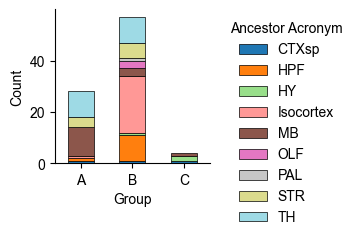

In [384]:
# plot the actual counts as a stacked barplot of ancestor acronyms for each category stored in all_metrics_df ancestor_acronym column
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate counts of ancestor acronyms for each category
ancestor_counts = all_metrics_df.groupby(['category', 'ancestor_acronym']).size().reset_index(name='count')

# Pivot the data to prepare for stacking
ancestor_counts_pivot = ancestor_counts.pivot(index='category', columns='ancestor_acronym', values='count').fillna(0)

# Reorder the index to match the desired order
ancestor_counts_pivot = ancestor_counts_pivot.reindex(['groupA', 'groupB', 'groupC'])

# Create a stacked barplot
fig = ancestor_counts_pivot.plot(kind='bar', stacked=True, figsize=(2, 2), colormap='tab20',linewidth = 0.5, edgecolor='black')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Ancestor Acronym', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
sns.despine()
plt.xticks([0, 1, 2], ["A","B","C"], rotation=0)
plt.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"),bbox_inches = 'tight', dpi=300)
plt.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"),bbox_inches = 'tight', dpi=300)


### Figure E to H

C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\3543981131.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

c:\Users\stuberadmin\anaconda3\envs\scanpy_py\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

groupA vs. groupB: t-test independent samples with Benjamini-Hochberg correction, P_val:1.048e-01 t=-1.640e+00
groupB vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:1.085e-01 t=1.630e+00
groupA vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:3.430e-01 t=9.634e-01


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\3543981131.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

groupA vs. groupB: t-test independent samples with Benjamini-Hochberg correction, P_val:1.692e-01 t=1.387e+00
groupB vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:9.551e-01 t=5.650e-02
groupA vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:6.150e-01 t=5.082e-01


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\3543981131.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

groupA vs. groupB: t-test independent samples with Benjamini-Hochberg correction, P_val:6.270e-11 t=-7.504e+00
groupB vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:2.913e-01 t=1.065e+00
groupA vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:2.726e-02 t=-2.321e+00


C:\Users\stuberadmin\AppData\Local\Temp;\ipykernel_141456\3543981131.py:25: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

groupA vs. groupB: t-test independent samples with Benjamini-Hochberg correction, P_val:6.178e-01 t=-5.008e-01
groupB vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:7.889e-01 t=2.690e-01
groupA vs. groupC: t-test independent samples with Benjamini-Hochberg correction, P_val:9.762e-01 t=3.014e-02


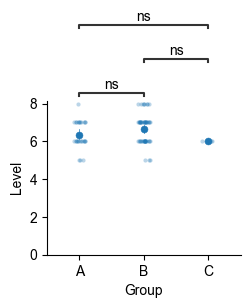

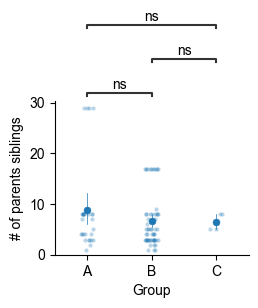

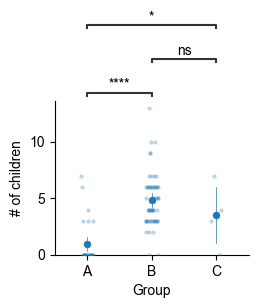

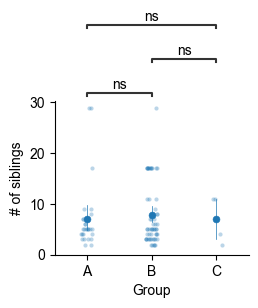

In [385]:
# run this for all parameters
from statannotations.Annotator import Annotator
pairs = [(brain_regions_category_name[0],brain_regions_category_name[1]),
        (brain_regions_category_name[0],brain_regions_category_name[2]),
        (brain_regions_category_name[1],brain_regions_category_name[2]),]
 
for pidx,param in enumerate(['depth','n_siblings_parent','n_children','n_siblings',]):
    pannel_key = ['E','F','G','H'][pidx]
    
    
    fig,axs = plt.subplots(1,1,figsize = (2.5,2))
    sns.stripplot(data = all_metrics_df,
                y = param,x = 'category',
                order = brain_regions_category_name,\
            ax = axs,alpha = 0.3,size = 3)
    sns.pointplot(data = all_metrics_df,
                y = param,x = 'category',
                order = brain_regions_category_name,
            ax = axs,
    markers="o", markersize=5, linestyle="none",linewidth = 0.5) 
    axs.set_ylim(0,)
    sns.despine()
    axs.set_ylabel(['Level','# of parents siblings','# of children','# of siblings'][pidx])
    axs.set_xlabel('Group')
    axs.set_xticklabels(['A','B','C'],rotation = 0)
    
    annotator = Annotator(axs, pairs, data = all_metrics_df,
                y = param,x = 'category', order=brain_regions_category_name)
    annotator.configure(test='t-test_ind', text_format='star', loc='outside',)
    annotator.configure(comparisons_correction="BH", correction_format="replace")
    annotator.apply_and_annotate()

    fig.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"), dpi=300, bbox_inches='tight')
    fig.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"), dpi=300, bbox_inches='tight')
    


## Figure I to M

Generate a random list of disjoint brain regions to use for statistical analysis

### Preparation

In [386]:
import random

def get_random_disjoint_nodes(atlas_df, num_nodes, random_state):
    """
    Get X random disjoint nodes from a tree dataset.
    Args:
        atlas_df (pd.DataFrame): The tree dataset with 'id', 'acronym', and 'parent_acronym' columns.
        num_nodes (int): Number of disjoint nodes to retrieve.
        random_state (int): Random seed for reproducibility.
    Returns:
        list: A list of disjoint node ids.
    """
    # Create a set to track selected nodes and their descendants
    selected_nodes = set()
    disjoint_nodes = []

    # Shuffle the dataset to randomize node selection
    shuffled_nodes = atlas_df.sample(frac=1, random_state=random_state).to_dict('records')

    for node in shuffled_nodes:
        # Check if the node or its ancestors/descendants are already selected
        current_node = node['acronym']
        is_disjoint = True

        # Check ancestors
        while current_node in atlas_df['acronym'].values:
            if current_node in selected_nodes:
                is_disjoint = False
                break
            current_node = atlas_df.loc[atlas_df['acronym'] == current_node, 'parent_acronym'].values[0]

        # Check descendants
        if is_disjoint:
            descendants = atlas_df.loc[atlas_df['parent_acronym'] == node['acronym'], 'acronym'].values
            if any(descendant in selected_nodes for descendant in descendants):
                is_disjoint = False

        # Add the node if it is disjoint
        if is_disjoint:
            disjoint_nodes.append(node['id'])
            selected_nodes.add(node['acronym'])
            selected_nodes.update(descendants)
            #print(node)
        # Stop if we have enough nodes
        if len(disjoint_nodes) == num_nodes:
            break

    # Check if the required number of nodes is met
    if len(disjoint_nodes) < num_nodes:
        return get_random_disjoint_nodes(atlas_df, num_nodes, random_state + 1001)

    return disjoint_nodes

# Example usage
random_disjoint_nodes = get_random_disjoint_nodes(atlas_df, 5, random_state=4)
print("Random disjoint node IDs:", random_disjoint_nodes)

Random disjoint node IDs: [2015, 2078, 217, 1047, 2367]


In [387]:
# get a sub atlas data frame
sub_atlas_df = sub_atlas_df[sub_atlas_df.acronym.isin(opioid_bh_comparison_df.acronym)].reset_index()

In [388]:
# run through 1000 iterations to get the disjoint nodes and calculate the probability of the rejection
import tqdm
for n_nodes in [5,10,20,50,100,200,400][2:]:
    if not n_nodes == 10:
        if os.path.exists(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'random_disjoint_nodes_{n_nodes}.npy')):
            print(f'random_disjoint_nodes_{n_nodes} already exists')
            #continue
    list_nodes = []
    for i in tqdm.tqdm(range(1000)):
        random_disjoint_nodes = get_random_disjoint_nodes(sub_atlas_df, n_nodes,random_state = i)
        # store the random_disjoint_nodes
        list_nodes.append(random_disjoint_nodes)
    # convert the list_nodes to a np array
    list_nodes = np.array(list_nodes)
    # write the list_nodes to a npy file
    np.save(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'random_disjoint_nodes_{n_nodes}.npy'),list_nodes)
    

random_disjoint_nodes_20 already exists


  5%|▌         | 54/1000 [00:01<00:23, 39.56it/s]


KeyboardInterrupt: 

In [279]:
# get the leaf nodes, leaf nodes can be defined by rows that have an id but doesnt appear in parent_id column
leaf_nodes = sub_atlas_df[~sub_atlas_df['acronym'].isin(sub_atlas_df['parent_acronym'])].reset_index()['id'].values
# write the list_nodes to a npy file
np.save(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'random_disjoint_nodes_{len(leaf_nodes)}.npy'),leaf_nodes)


In [257]:
def calculate_metrics_by_category(opioid_bh_comparison_df,curated_idx):
    # calculate the metrics for sets of brain regions in the brain_regions_category
    # Prepare data for Venn diagram
    treebh_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['TreeBH_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
    flatbh_fishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)
    flatbh_nonfishers_rejected = set(opioid_bh_comparison_df[(opioid_bh_comparison_df['flatbh_non-Fishers_rejected'] == True)&(opioid_bh_comparison_df.acronym.isin(curated_acronyms))].acronym.values)

    # find the common in treebh_rejected, flatbh_fishers_rejected, flatbh_nonfishers_rejected
    groupA = treebh_rejected & flatbh_fishers_rejected & flatbh_nonfishers_rejected

    # find the common in treebh_rejected and flatbh_fishers_rejected but not in flatbh_nonfishers_rejected
    groupB = (treebh_rejected & flatbh_fishers_rejected) - flatbh_nonfishers_rejected

    # find only in flatbh_fishers_rejected but not in treebh_rejected and not in flatbh_nonfishers_rejected
    groupC = (flatbh_fishers_rejected - treebh_rejected) - flatbh_nonfishers_rejected


    # get the ancesotr acronyms 
    groupA_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                            for f in groupA]
    groupB_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                            for f in groupB]                           
    groupC_ancestor = [np.array(ancestor_curated_acronyms)[np.where(np.array(curated_acronyms) == f)][0]\
                            for f in groupC]

    brain_regions_category = [groupA,groupB,groupC]
    brain_regions_category_name = ['groupA','groupB','groupC']

    for bidx,brain_regions in enumerate(brain_regions_category):
        brain_regions = np.array(list(brain_regions))
        ancestor_acronyms = [get_ancestor_acronym(atlas_df,acronym) for acronym in brain_regions]
        n_siblings_list = [get_n_siblings(atlas_df,acronym) for acronym in brain_regions]
        n_children_list = [get_n_children(atlas_df,acronym) for acronym in brain_regions]
        n_siblings_parent_list = [get_n_siblings_parent(atlas_df,acronym) for acronym in brain_regions]
        depth_list = [get_depth(atlas_df,acronym) for acronym in brain_regions]
        # create a dataframe to store the metrics
        metrics_df = pd.DataFrame({
            'ancestor_acronym': ancestor_acronyms,
            'n_siblings': n_siblings_list,
            'n_children': n_children_list,
            'n_siblings_parent': n_siblings_parent_list,
            'depth': depth_list,
        },index = brain_regions)
        metrics_df['category'] = brain_regions_category_name[bidx]

        # merge the metrics_df from the iterations to one
        if bidx == 0:
            all_metrics_df = metrics_df.copy()
        else:
            all_metrics_df = pd.concat([all_metrics_df,metrics_df],axis = 0)
    return all_metrics_df

In [259]:
def calculate_flatbh_Fishers(opioid_bh_comparison_df,curated_indexes, FDR = 0.01):
    """
    Calculate the flat BH Fisher's method for the given dataframe and curated indexes.
    
    Args:
        opioid_bh_comparison_df (pd.DataFrame): The dataframe containing p-values and other information.
        curated_indexes (list): List of curated indexes to filter the dataframe.
        FDR (float): False Discovery Rate threshold for multiple testing correction.
        
    Returns:
        pd.DataFrame: Dataframe with flat BH Fisher's results.
    """
    # Get the p-values for the curated indexes
    fishers_pvals = opioid_bh_comparison_df.loc[curated_indexes,'p.val']
    
    # Perform multiple testing correction using FDR
    multiple_testing_results = multitests.multipletests(fishers_pvals, alpha=FDR, method='fdr_bh')
    
    # Add results to the dataframe
    opioid_bh_comparison_df.loc[curated_indexes,'flatbh_Fishers_rejected'] = multiple_testing_results[0]
    opioid_bh_comparison_df.loc[curated_indexes,'flatbh_Fishers_p_val'] = multiple_testing_results[1]
    
    return opioid_bh_comparison_df

def calculate_nonflatbh_Fishers(opioid_bh_comparison_df,curated_indexes, FDR = 0.01):
    """
    Calculate the non-flat BH Fisher's method for the given dataframe and curated indexes.
    
    Args:
        opioid_bh_comparison_df (pd.DataFrame): The dataframe containing p-values and other information.
        curated_indexes (list): List of curated indexes to filter the dataframe.
        FDR (float): False Discovery Rate threshold for multiple testing correction.
        
    Returns:
        pd.DataFrame: Dataframe with non-flat BH Fisher's results.
    """
    # Get the p-values for the curated indexes
    nonfishers_pvals = opioid_bh_comparison_df.loc[curated_indexes,'non-Fishers_p_val']
    
    # Perform multiple testing correction using FDR
    multiple_testing_results = multitests.multipletests(nonfishers_pvals, alpha=FDR, method='fdr_bh')
    
    # Add results to the dataframe
    opioid_bh_comparison_df.loc[curated_indexes,'flatbh_non-Fishers_rejected'] = multiple_testing_results[0]
    opioid_bh_comparison_df.loc[curated_indexes,'flatbh_non-Fishers_p_val'] = multiple_testing_results[1]
    
    return opioid_bh_comparison_df

Loop through all n_nodes brain regions list, first collect metrics

In [389]:
opioid_bh_comparison_df = pd.read_csv(os.path.join(analysis_resultpath, f"{figure_key}_opioid_bh_comparison_df.csv"), index_col = False)

In [390]:
# clean up the comparison_df
opioid_bh_comparison_df = opioid_bh_comparison_df.set_index('acronym').join(atlas_df.set_index('acronym')[['id','parent_id']]).reset_index()
opioid_bh_comparison_df = opioid_bh_comparison_df.iloc[1:,]
opioid_bh_comparison_df = opioid_bh_comparison_df.set_index('id')
# update the comparison_df with the pvalues from the opioid_stat_df
opioid_bh_comparison_df = opioid_bh_comparison_df.join(opioid_stat_df.set_index('id')['pvalue']).rename(columns = {'pvalue':'non-Fishers_p_val'})

In [392]:
FDR

0.001

In [393]:
for n_nodes in [5,10,20,50,100,200,400] + [len(leaf_nodes)]:
    print("processing n_nodes = ",n_nodes)   
    list_nodes = np.load(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'random_disjoint_nodes_{n_nodes}.npy'))
    if n_nodes == len(leaf_nodes):
        list_nodes = [list_nodes]

    discovery_date_list = []
    metrics_list = []
    combined_metrics_df = pd.DataFrame()
    from tqdm import tqdm

    for list_node in tqdm(list_nodes):
        opioid_bh_comparison_df = calculate_flatbh_Fishers(opioid_bh_comparison_df, list_node, FDR=FDR)
        opioid_bh_comparison_df = calculate_nonflatbh_Fishers(opioid_bh_comparison_df, list_node, FDR=FDR)

        tdiscovery_rate = np.sum(opioid_bh_comparison_df.loc[list_node, ['TreeBH_rejected', 'flatbh_Fishers_rejected', 'flatbh_non-Fishers_rejected']] == True, axis=0).values / n_nodes
        discovery_date_list.append(tdiscovery_rate)

        all_metrics_df = calculate_metrics_by_category(opioid_bh_comparison_df, list_node)
        all_metrics_df = all_metrics_df[['n_siblings','n_children','n_siblings_parent','depth','category']].groupby('category').mean().reset_index()
            
        combined_metrics_df = pd.concat([combined_metrics_df, all_metrics_df], axis=0)

    discovery_date_list = np.array(discovery_date_list)
    discovery_date_list = pd.DataFrame(discovery_date_list, columns=['TreeBH', 'flatbh_Fishers', 'flatbh_non-Fishers'])
    discovery_date_list.to_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results', f'discovery_rate_{n_nodes}.csv'), index=False)

    combined_metrics_df.to_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results', f'all_metrics_{n_nodes}.csv'), index=False)

processing n_nodes =  5


100%|██████████| 1000/1000 [02:06<00:00,  7.93it/s]


processing n_nodes =  10


100%|██████████| 1000/1000 [02:09<00:00,  7.71it/s]


processing n_nodes =  20


100%|██████████| 1000/1000 [02:41<00:00,  6.21it/s]


processing n_nodes =  50


100%|██████████| 1000/1000 [02:58<00:00,  5.59it/s]


processing n_nodes =  100


100%|██████████| 1000/1000 [02:06<00:00,  7.88it/s]


processing n_nodes =  200


100%|██████████| 1000/1000 [02:06<00:00,  7.92it/s]


processing n_nodes =  400


100%|██████████| 1000/1000 [02:07<00:00,  7.87it/s]


processing n_nodes =  807


100%|██████████| 1/1 [00:00<00:00,  7.84it/s]


In [410]:

for idx,n_nodes in enumerate([5,10,20,50,100,200,400] + [len(leaf_nodes)]):   
    combined_metrics_df = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'all_metrics_{n_nodes}.csv'), index_col = False)
    combined_metrics_df['n_nodes'] = n_nodes
    if idx == 0:
        sum_combined_metrics_df = combined_metrics_df
    else:
        sum_combined_metrics_df = pd.concat([sum_combined_metrics_df,combined_metrics_df],axis = 0)


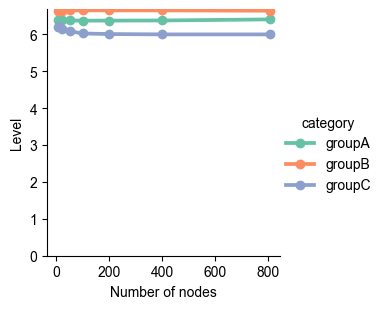

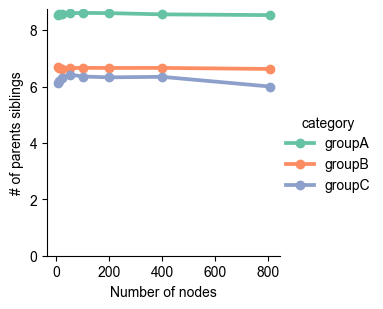

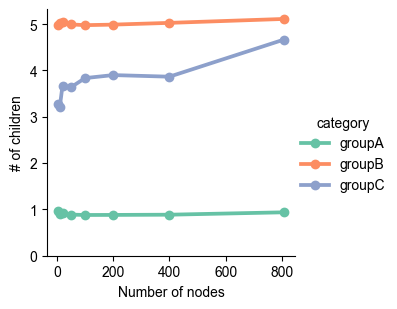

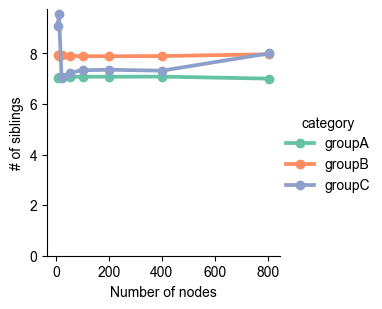

In [413]:
# loop through variables
for pidx,var in enumerate(['depth','n_siblings_parent','n_children','n_siblings',]):
    pannel_key = ['J','K','L','M'][pidx]
    g = sns.catplot(data = sum_combined_metrics_df.dropna(),
                    x = 'n_nodes',y = var,hue = 'category',native_scale=True,
                    kind = 'point',errorbar = 'se',height = 3.2,palette = 'Set2',markersize = 5)
    # set the y axis to start from 0
    g.set(ylim=(0, None))
    plt.ylabel(['Level','# of parents siblings','# of children','# of siblings'][pidx])
    plt.xlabel('Number of nodes')
    #plt.xticks([5,10,20,50,100,200,400] + [len(leaf_nodes)],\
    #    ['5','10','20','50','100','200','400'] + [f'{len(leaf_nodes)}\n(leaf nodes)'])
    g.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"), dpi=300, bbox_inches='tight')
    g.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"), dpi=300, bbox_inches='tight')
   

### Figure I

In [414]:
pannel_key = 'I'

In [415]:

for idx,n_nodes in enumerate([5,10,20,50,100,200,400] + [len(leaf_nodes)]):   
    discovery_date_list = pd.read_csv(os.path.join(r"G:\My Drive\Opioid_whole_brain_manuscript\TreeBH comparison",'results',f'discovery_rate_{n_nodes}.csv'), index_col = False)
    discovery_date_list['n_nodes'] = n_nodes
    if idx == 0:
        sum_discovery_date_list = discovery_date_list
    else:
        sum_discovery_date_list = pd.concat([sum_discovery_date_list,discovery_date_list],axis = 0)


In [416]:
sum_discovery_date_list = sum_discovery_date_list.set_index('n_nodes').stack().reset_index().rename(columns = {'level_1':'Method','n_nodes':'n_nodes',0:'proportion of discovery'})

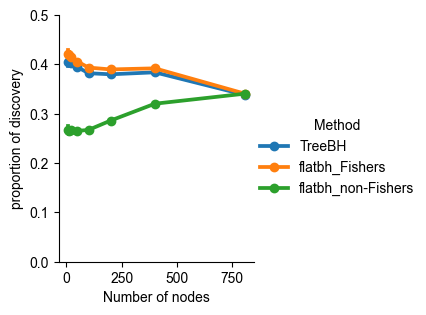

In [418]:
g = sns.catplot(data = sum_discovery_date_list,x = 'n_nodes',y = 'proportion of discovery',\
            hue = 'Method',kind = 'point',errorbar = 'se',height = 3.2,native_scale=True,markersize = 5)
            
plt.ylim(0,0.5)
plt.xlabel('Number of nodes')
g.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.png"), dpi=300, bbox_inches='tight')
g.savefig(os.path.join(analysis_figurepath, f"{figure_key}{pannel_key}.pdf"), dpi=300, bbox_inches='tight')
